In [245]:
%matplotlib inline

import ast
import matplotlib.pyplot as plt
import pandas as pd
import requests
import seaborn as sns

from pprint import pprint

## Settings

In [246]:
FIG_DPI = 160
FIG_SIZE = [16, 9]

plt.rcParams['figure.figsize'] = FIG_SIZE
plt.rcParams['figure.dpi'] = FIG_DPI

sns.set()
# sns.set_palette('husl')
sns.set_style('darkgrid')

## Parameters

In [111]:
PORTALS = {
    'data.gov.uk': {
        'url': 'https://ckan.publishing.service.gov.uk/api/3',
        'theme-field': 'theme-primary'
    },
    'data.kdl.kcl.ac.uk': {
        'url': 'https://data.kdl.kcl.ac.uk/api/3',
        'theme-field': 'theme-primary'
    }
}

## Helper functions

In [112]:
def do_get(url):
    if not url:
        return None
    
    r = requests.get(url)
    
    if r.status_code != requests.codes.ok:
        r.raise_for_status()
        
    return r.json()

In [113]:
def get_extensions(portal):
    """Returns a dictionary of the extensions used in the portal."""
    if not portal:
        return None
    
    url = '{}/action/status_show'.format(portal)
    data = do_get(url)
    
    if not data:
        return None
    
    data = data['result']['extensions']
    
    return {
        k: 1 for k in data
    }

In [114]:
def get_tags(portal):
    """Returns a dictionary of the tags used in the portal. The tags are sorted alphabetically."""
    if not portal:
        return None
    
    url = '{}/action/package_search?facet.field=["tags"]&facet.limit=-1&facet.mincount=2'.format(portal)
    data = do_get(url)
    
    if not data:
        return None
    
    data = data['result']['facets']['tags']
    data = dict(sorted(data.items(), key=lambda t: t[0].lower()))
        
    return data

In [115]:
def get_themes(portal, theme_field):
    """Returns a dictionary of the themes used in the portal. The themes are sorted alphabetically."""
    if not portal:
        return None
    
    url = '{}/action/package_search?facet.field=["{}"]&facet.limit=-1'.format(portal, theme_field)
    data = do_get(url)
    
    if not data:
        return None
        
    data = data['result']['facets'][theme_field]
    data = dict(sorted(data.items(), key=lambda t: t[0].lower()))
        
    return data

In [185]:
def get_packages(portal, limit=100):
    if not portal:
        return None
    
    url = '{}/action/package_list'.format(portal)
    data = do_get(url)
    
    if not data or 'result' not in data:
        return None
    
    size = len(data['result'])
    if size == 0:
        return None
    
    packages = []
    
    for offset in range(0, size, limit):
        url = '{}/action/current_package_list_with_resources?limit={}&offset={}'.format(portal, limit, offset)
        data = do_get(url)
        
        if not data or 'result' not in data:
            yield
        
        for item in data['result']:
            yield item
        
    return

In [117]:
def add_dict_to_df(df, data, index=None):
    """Adds a dictionary to a pandas dataframe."""
    if not isinstance(data, list):
        data = [data]
        
    if index and not isinstance(index, list):
        index = [index]
        
    if index:
        new_df = pd.DataFrame(data, index=index)
    else:
        new_df = pd.DataFrame(data)
        
    return df.append(new_df, sort=False)

In [118]:
def flatten_dict(d):
    def items():
        for key, value in d.items():
            if isinstance(value, dict):
                for child_key, child_value in flatten_dict(value).items():
                    yield '{}:{}'.format(key, child_key), child_value
            else:
                yield key, value

    return dict(items())

In [143]:
def convert_df_to_numeric(df, columns=[], errors='ignore'):
    """Converts all the columns in the dataframe to numeric.
    If the columns argument is given, it converts only the given columns.
    By default it ignores conversion errors."""
    if columns:
        return df[columns].apply(pd.to_numeric, errors=errors)
        
    return df.apply(pd.to_numeric, errors=errors)

In [219]:
def split_tags(tags):
    if not tags:
        return
    
    if not isinstance(tags, list):
        tags = ast.literal_eval(tags)
    
    return [t['name'] for t in tags]

## Harvest data from the portals
### Extensions

In [278]:
exts_df = pd.DataFrame()

for k in PORTALS.keys():
    portal = PORTALS[k]
    
    exts = get_extensions(portal['url'])
    exts[k] = k
    
    exts_df = add_dict_to_df(exts_df, exts, k)

### Tags

In [279]:
tags_df = pd.DataFrame()

for k in PORTALS.keys():
    portal = PORTALS[k]
    
    tags = get_tags(portal['url'])
    tags[k] = k
    
    tags_df = add_dict_to_df(tags_df, tags, k)

### Themes

In [280]:
themes_df = pd.DataFrame()

for k in PORTALS.keys():
    portal = PORTALS[k]
    
    themes = get_themes(portal['url'], portal['theme-field'])
    themes[k] = k
    
    themes_df = add_dict_to_df(themes_df, themes, k)

### Packages

In [281]:
# this is very time consuming to run for data.gov.uk, it has been done and saved to csv, and is loaded further down
# packages_df = pd.DataFrame()

# for k in PORTALS.keys():
#     portal = PORTALS[k]

#     packages = get_packages(portal['url'])
    
#     for p in packages:
#         del p['resources']
        
#         p['__portal__'] = k
#         p = flatten_dict(p)
        
#         packages_df = add_dict_to_df(packages_df, p)
    
# packages_df.to_csv('packages.csv')

## Prepare the data
### Extensions

In [282]:
exts_df = exts_df.transpose()
exts_df = exts_df.drop(PORTALS.keys())
exts_df = convert_df_to_numeric(exts_df)
exts_df = exts_df.sort_index()
# exts_df = exts_df.fillna(0)

### Tags

In [283]:
tags_df = tags_df.transpose()
tags_df = tags_df.drop(PORTALS.keys())
tags_df = convert_df_to_numeric(tags_df)
# tags_df = tags_df.fillna(0)

### Themes

In [284]:
themes_df = themes_df.transpose()
themes_df = themes_df.drop(PORTALS.keys())
themes_df = convert_df_to_numeric(themes_df)
# themes_df = themes_df.fillna(0)

### Packages

In [285]:
packages_df = pd.read_csv('packages.csv')
packages_df = packages_df.drop(columns=['Unnamed: 0'])
# packages_df = convert_df_to_numeric(packages_df)
packages_df['tags'] = packages_df['tags'].apply(lambda t: split_tags(t))

/Users/jvieira/.local/share/virtualenvs/data-portal-explorer-fLnEQpYo/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (4,16,51,76,77,78,79,80,81,82,83,84) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Visualise
### Extensions

In [286]:
exts_df.head()

,data.gov.uk,data.kdl.kcl.ac.uk
ckan_harvester,1.0,NaN
csw_harvester,1.0,NaN
datagovsg_s3_resources,1.0,NaN
datagovuk,1.0,NaN
datagovuk_publisher_form,1.0,NaN


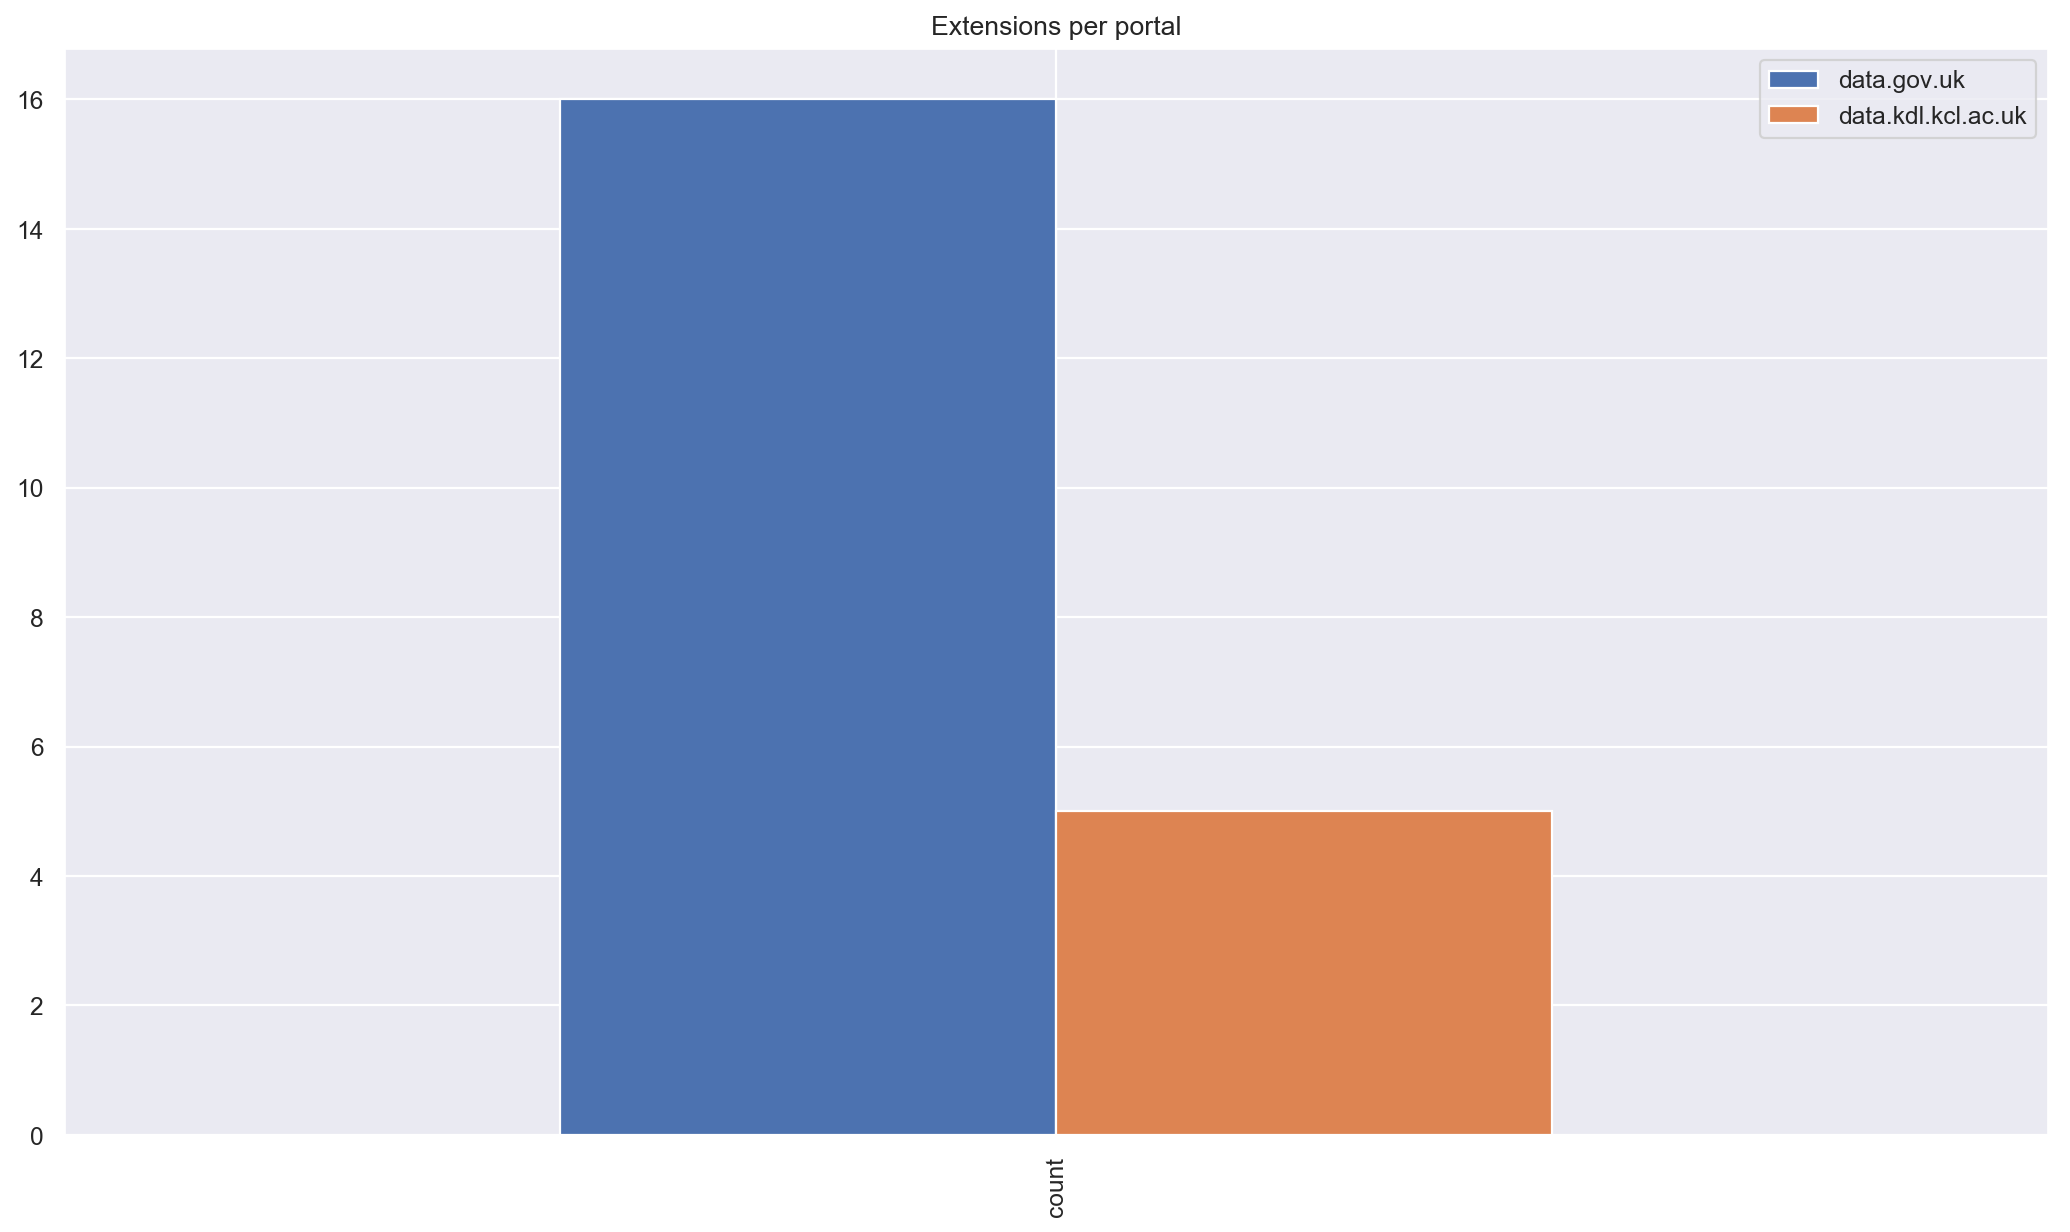

In [301]:
exts_df.describe()[:1].plot.bar(title='Extensions per portal')

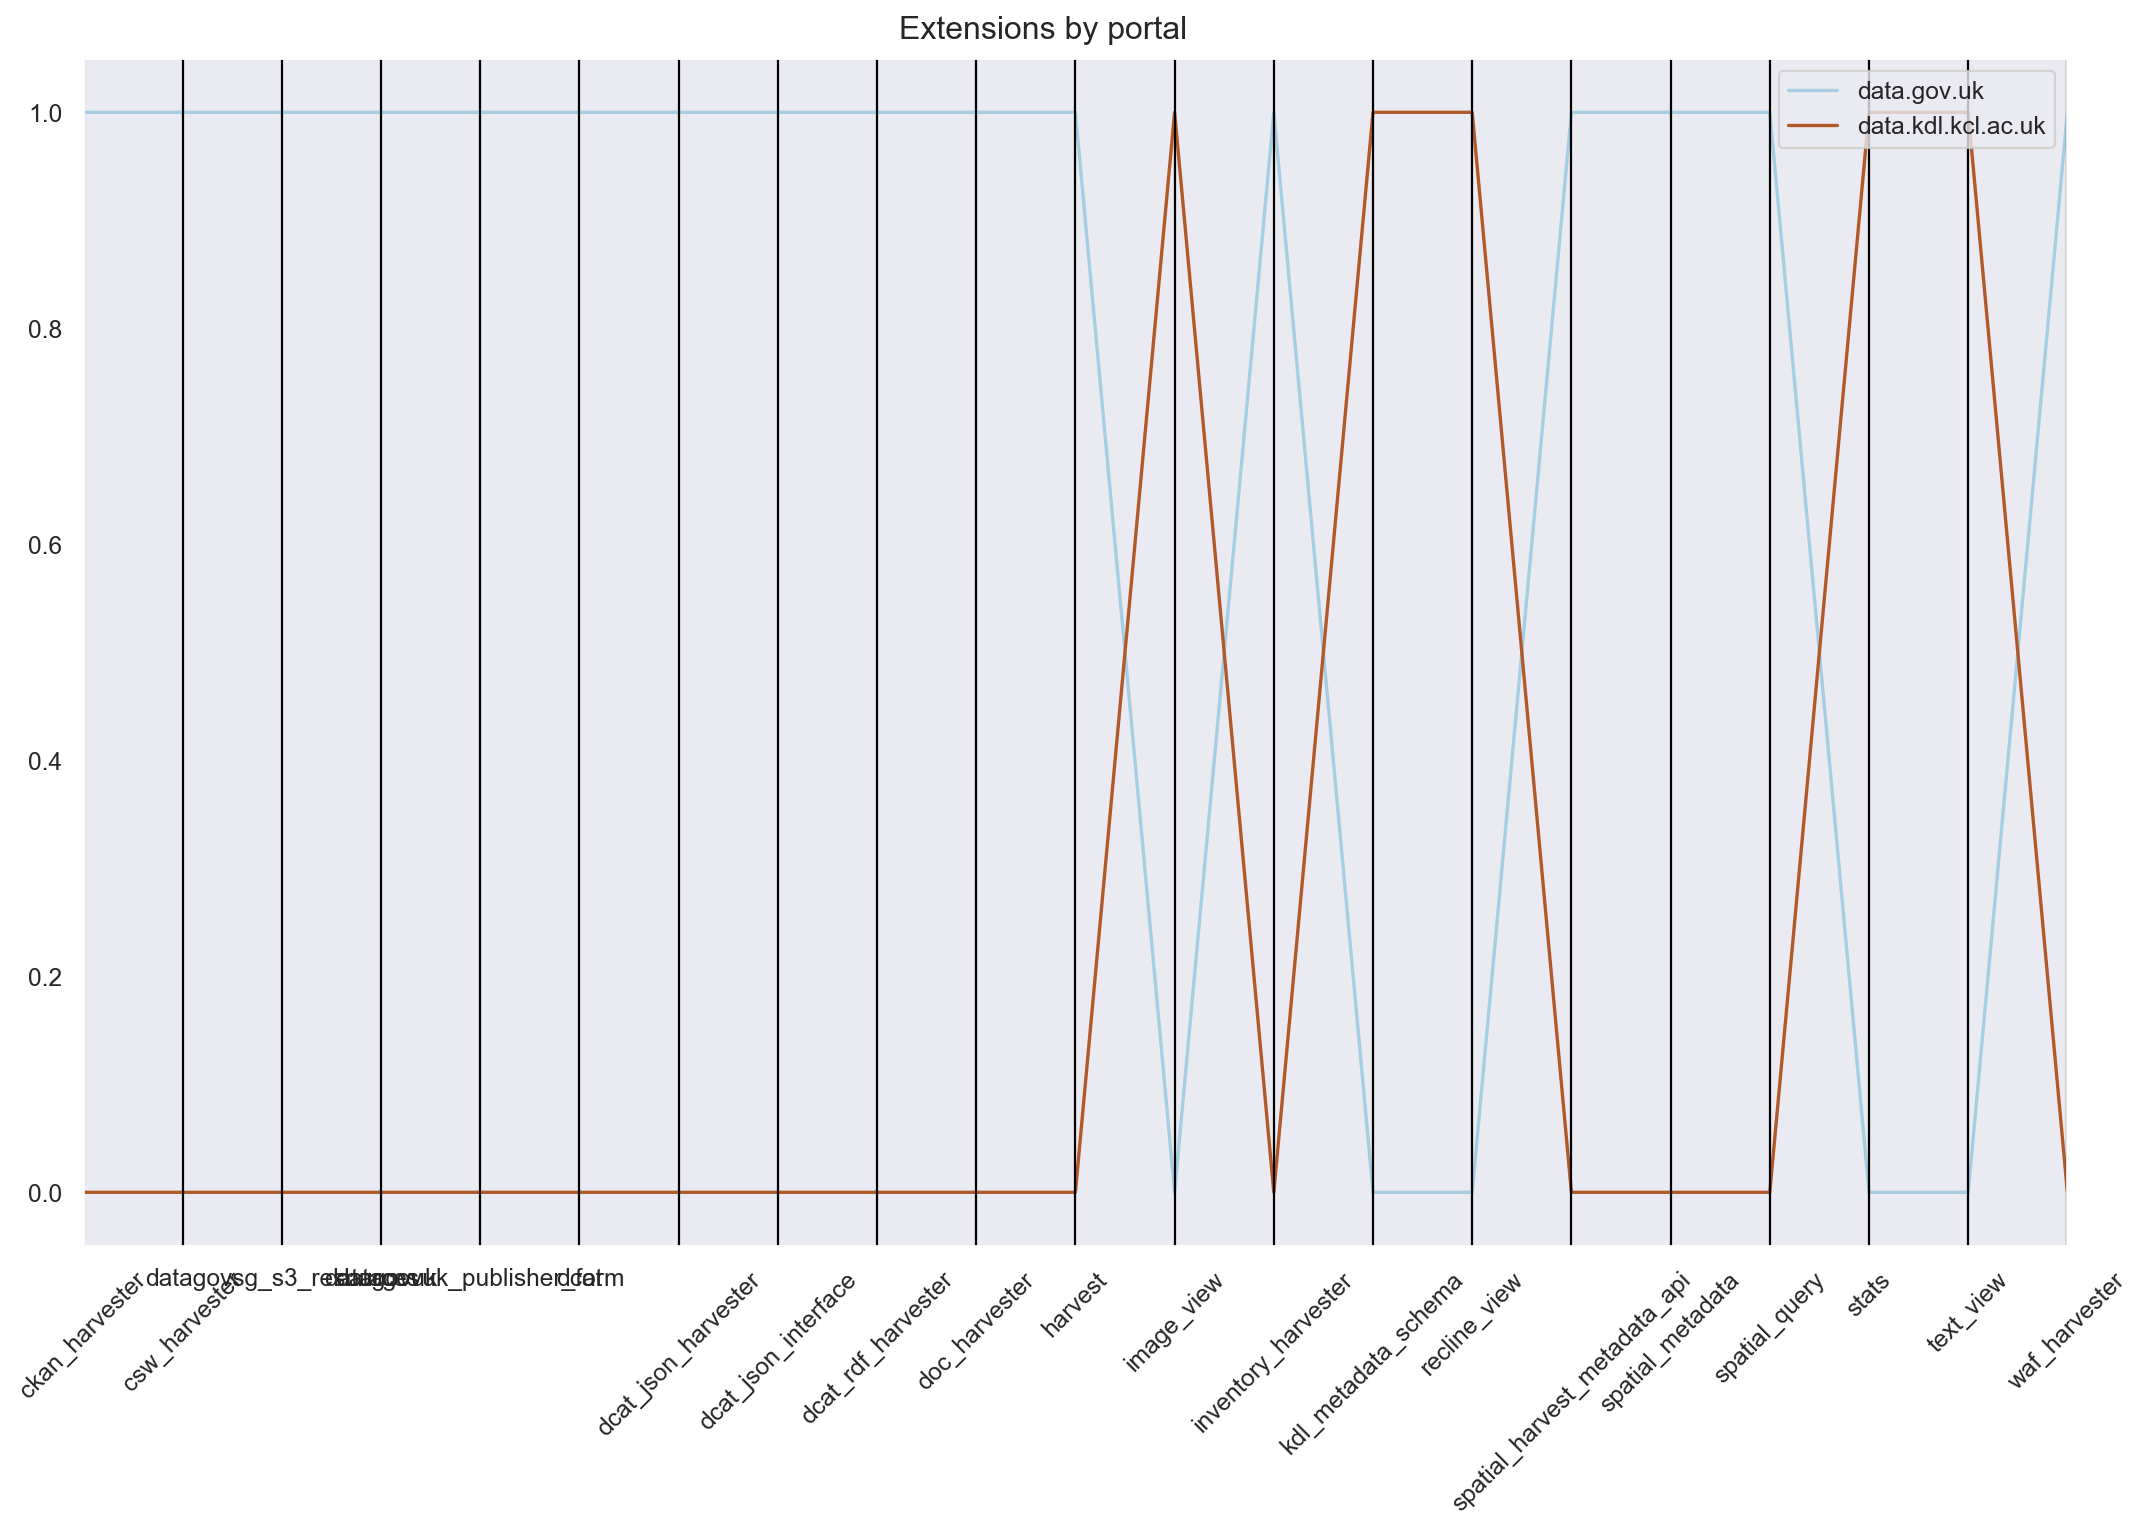

In [288]:
exts_parallel = exts_df.fillna(0)
exts_parallel = exts_parallel.transpose().reset_index()

fig, (ax) = plt.subplots(1, 1, figsize=FIG_SIZE)
fig.subplots_adjust(top=0.95)
fig.suptitle('Extensions by portal')

ax.set_xticklabels(exts_parallel['index'], rotation=45)

pd.plotting.parallel_coordinates(exts_parallel, 'index', colormap='Paired', sort_labels=True)

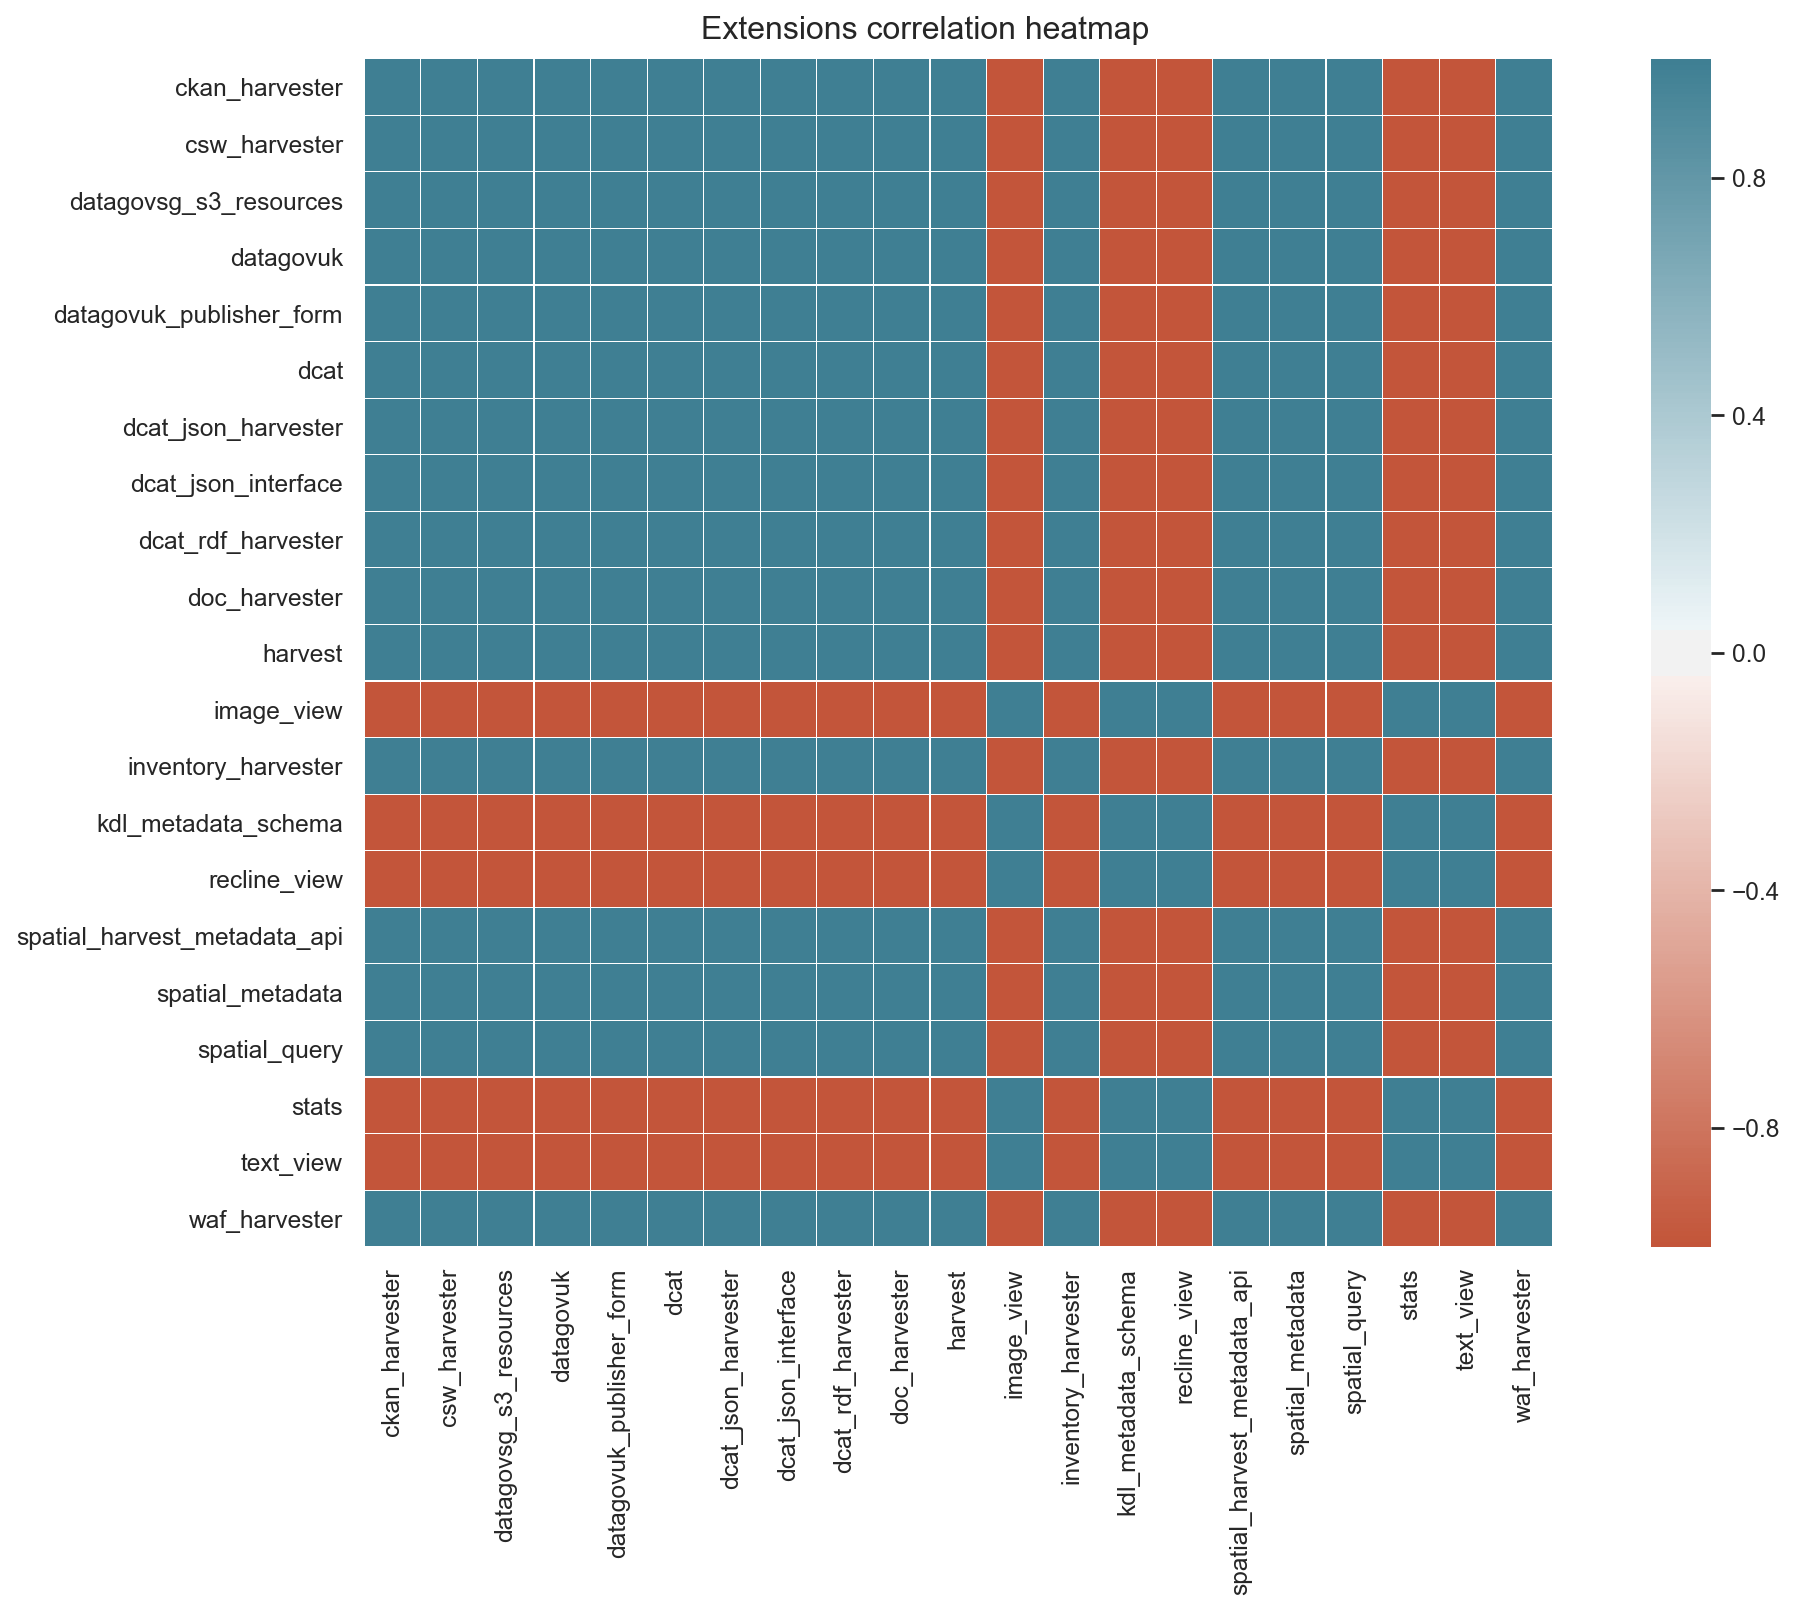

In [289]:
exts_corr = exts_df.fillna(0)
exts_corr = exts_corr.transpose().corr()

fig, (ax) = plt.subplots(1, 1, figsize=FIG_SIZE)
fig.subplots_adjust(top=0.95)
fig.suptitle('Extensions correlation heatmap')

hm = sns.heatmap(exts_corr, ax=ax, cmap=sns.diverging_palette(20, 220, n=exts_corr.size), linewidths=.05, square=True)

### Tags

In [290]:
tags_df.head()

,data.gov.uk,data.kdl.kcl.ac.uk
1200c,2.0,NaN
1991,2.0,NaN
2001,40.0,NaN
2001 census,2.0,NaN
2003,4.0,NaN


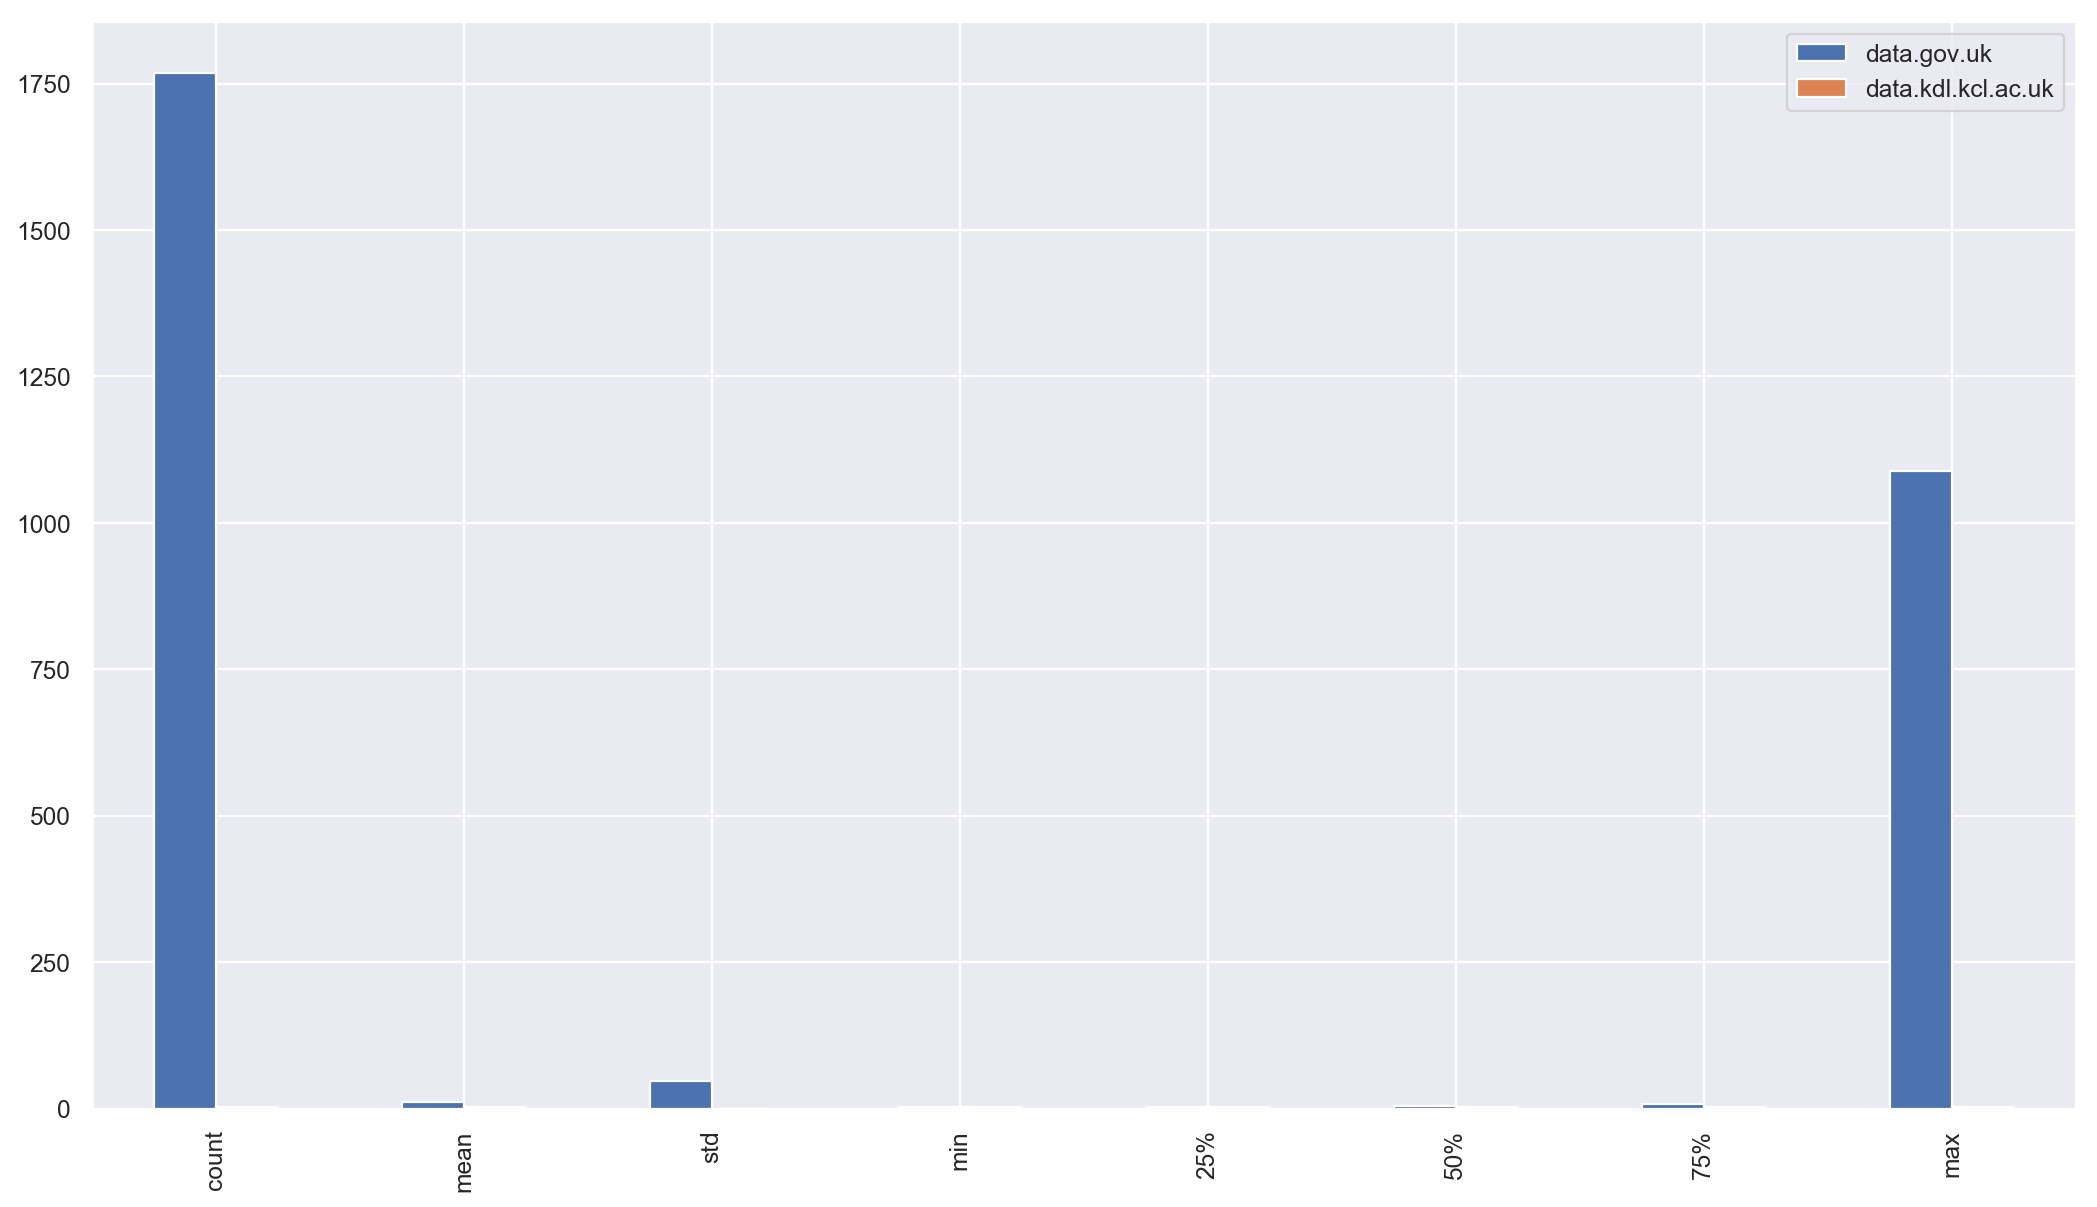

In [291]:
tags_df.describe().plot.bar()

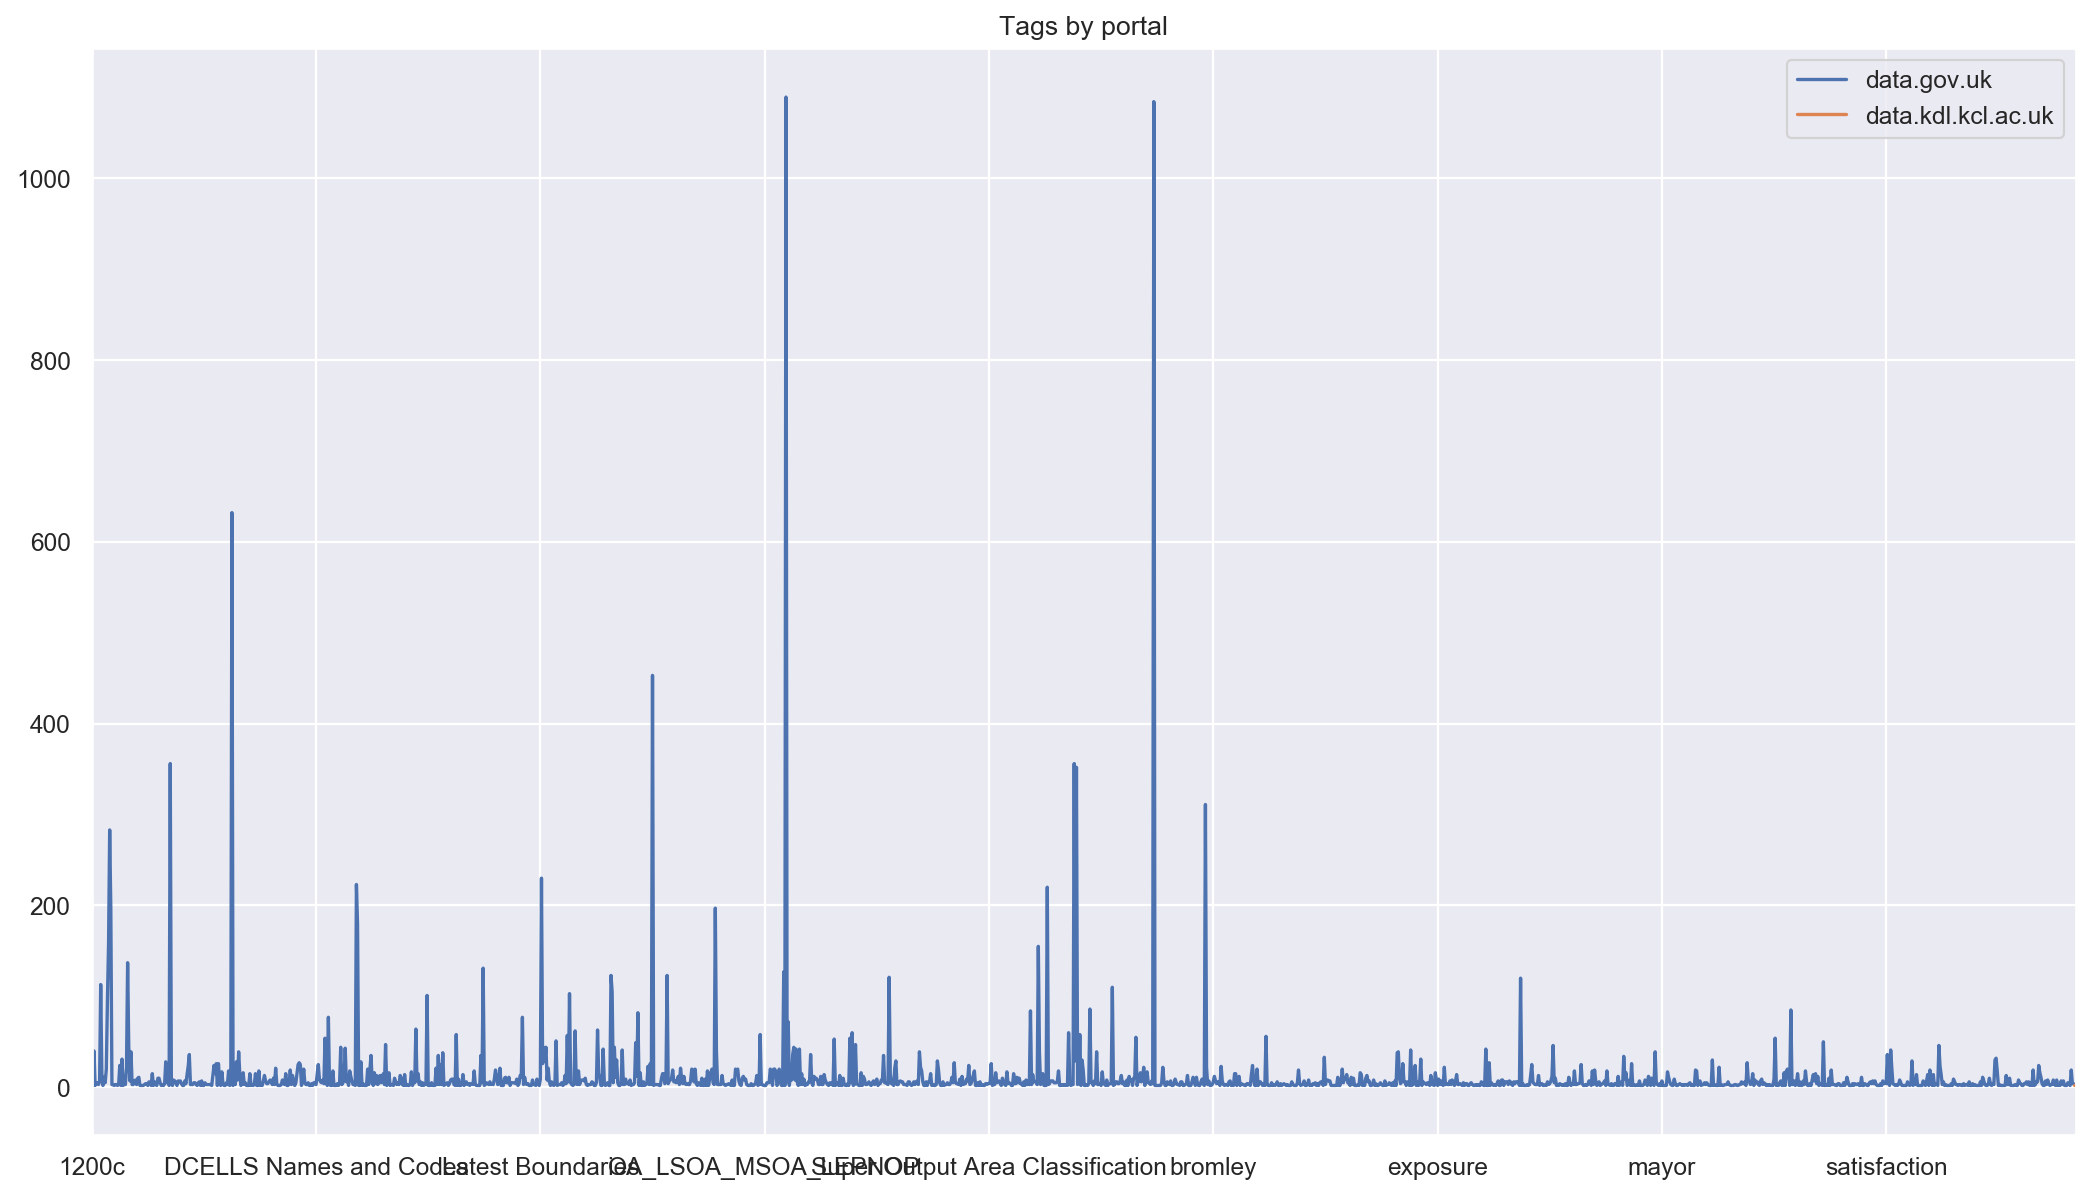

In [292]:
tags_df.plot(title='Tags by portal')

### Themes

In [293]:
themes_df.head()

,data.gov.uk,data.kdl.kcl.ac.uk
business-and-economy,1093.0,NaN
crime-and-justice,705.0,NaN
defence,187.0,NaN
education,1250.0,NaN
environment,12678.0,NaN


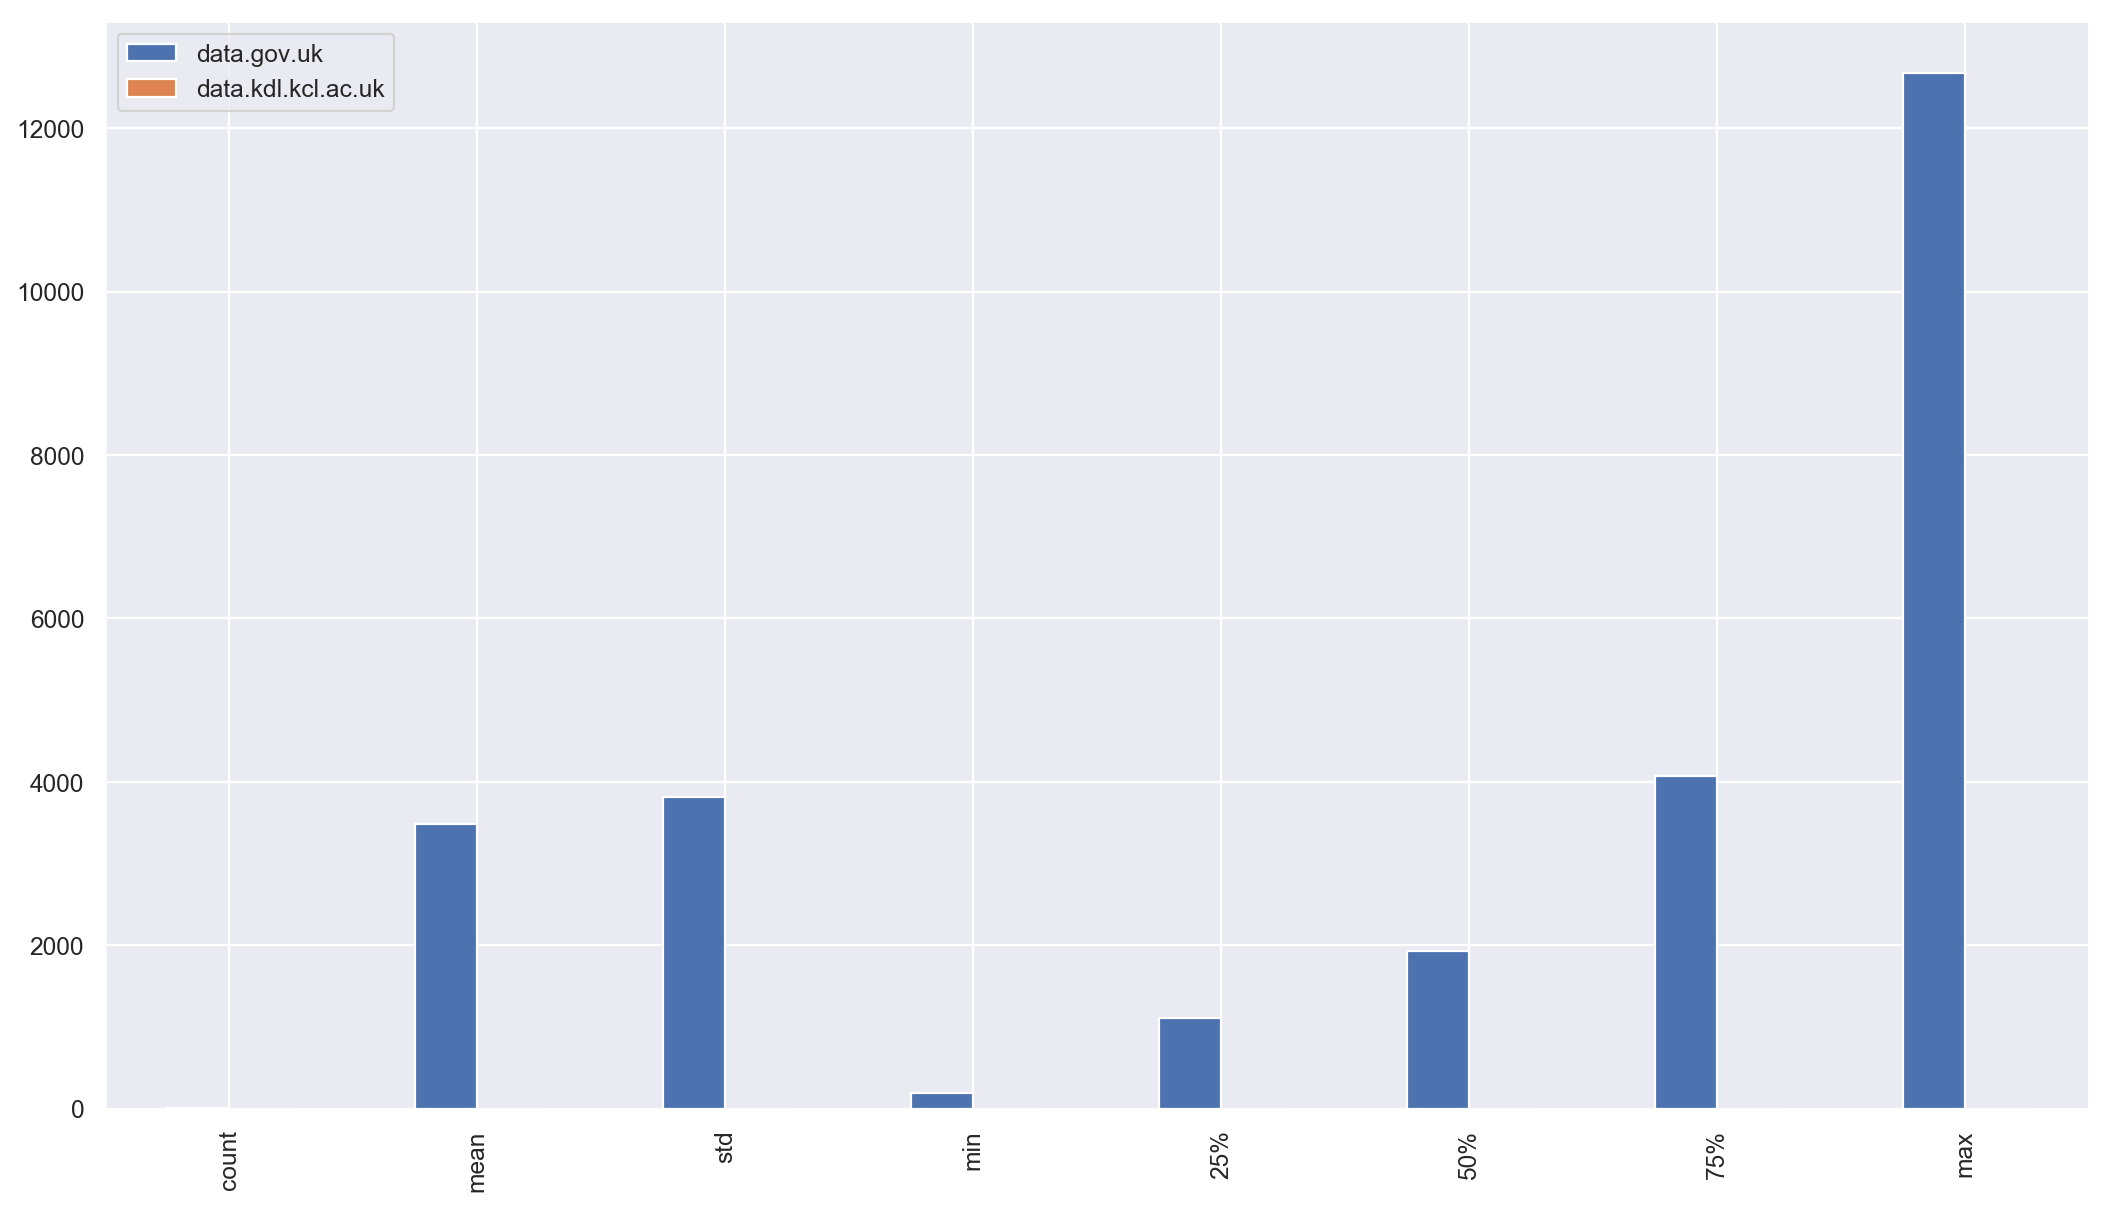

In [294]:
themes_df.describe().plot.bar()

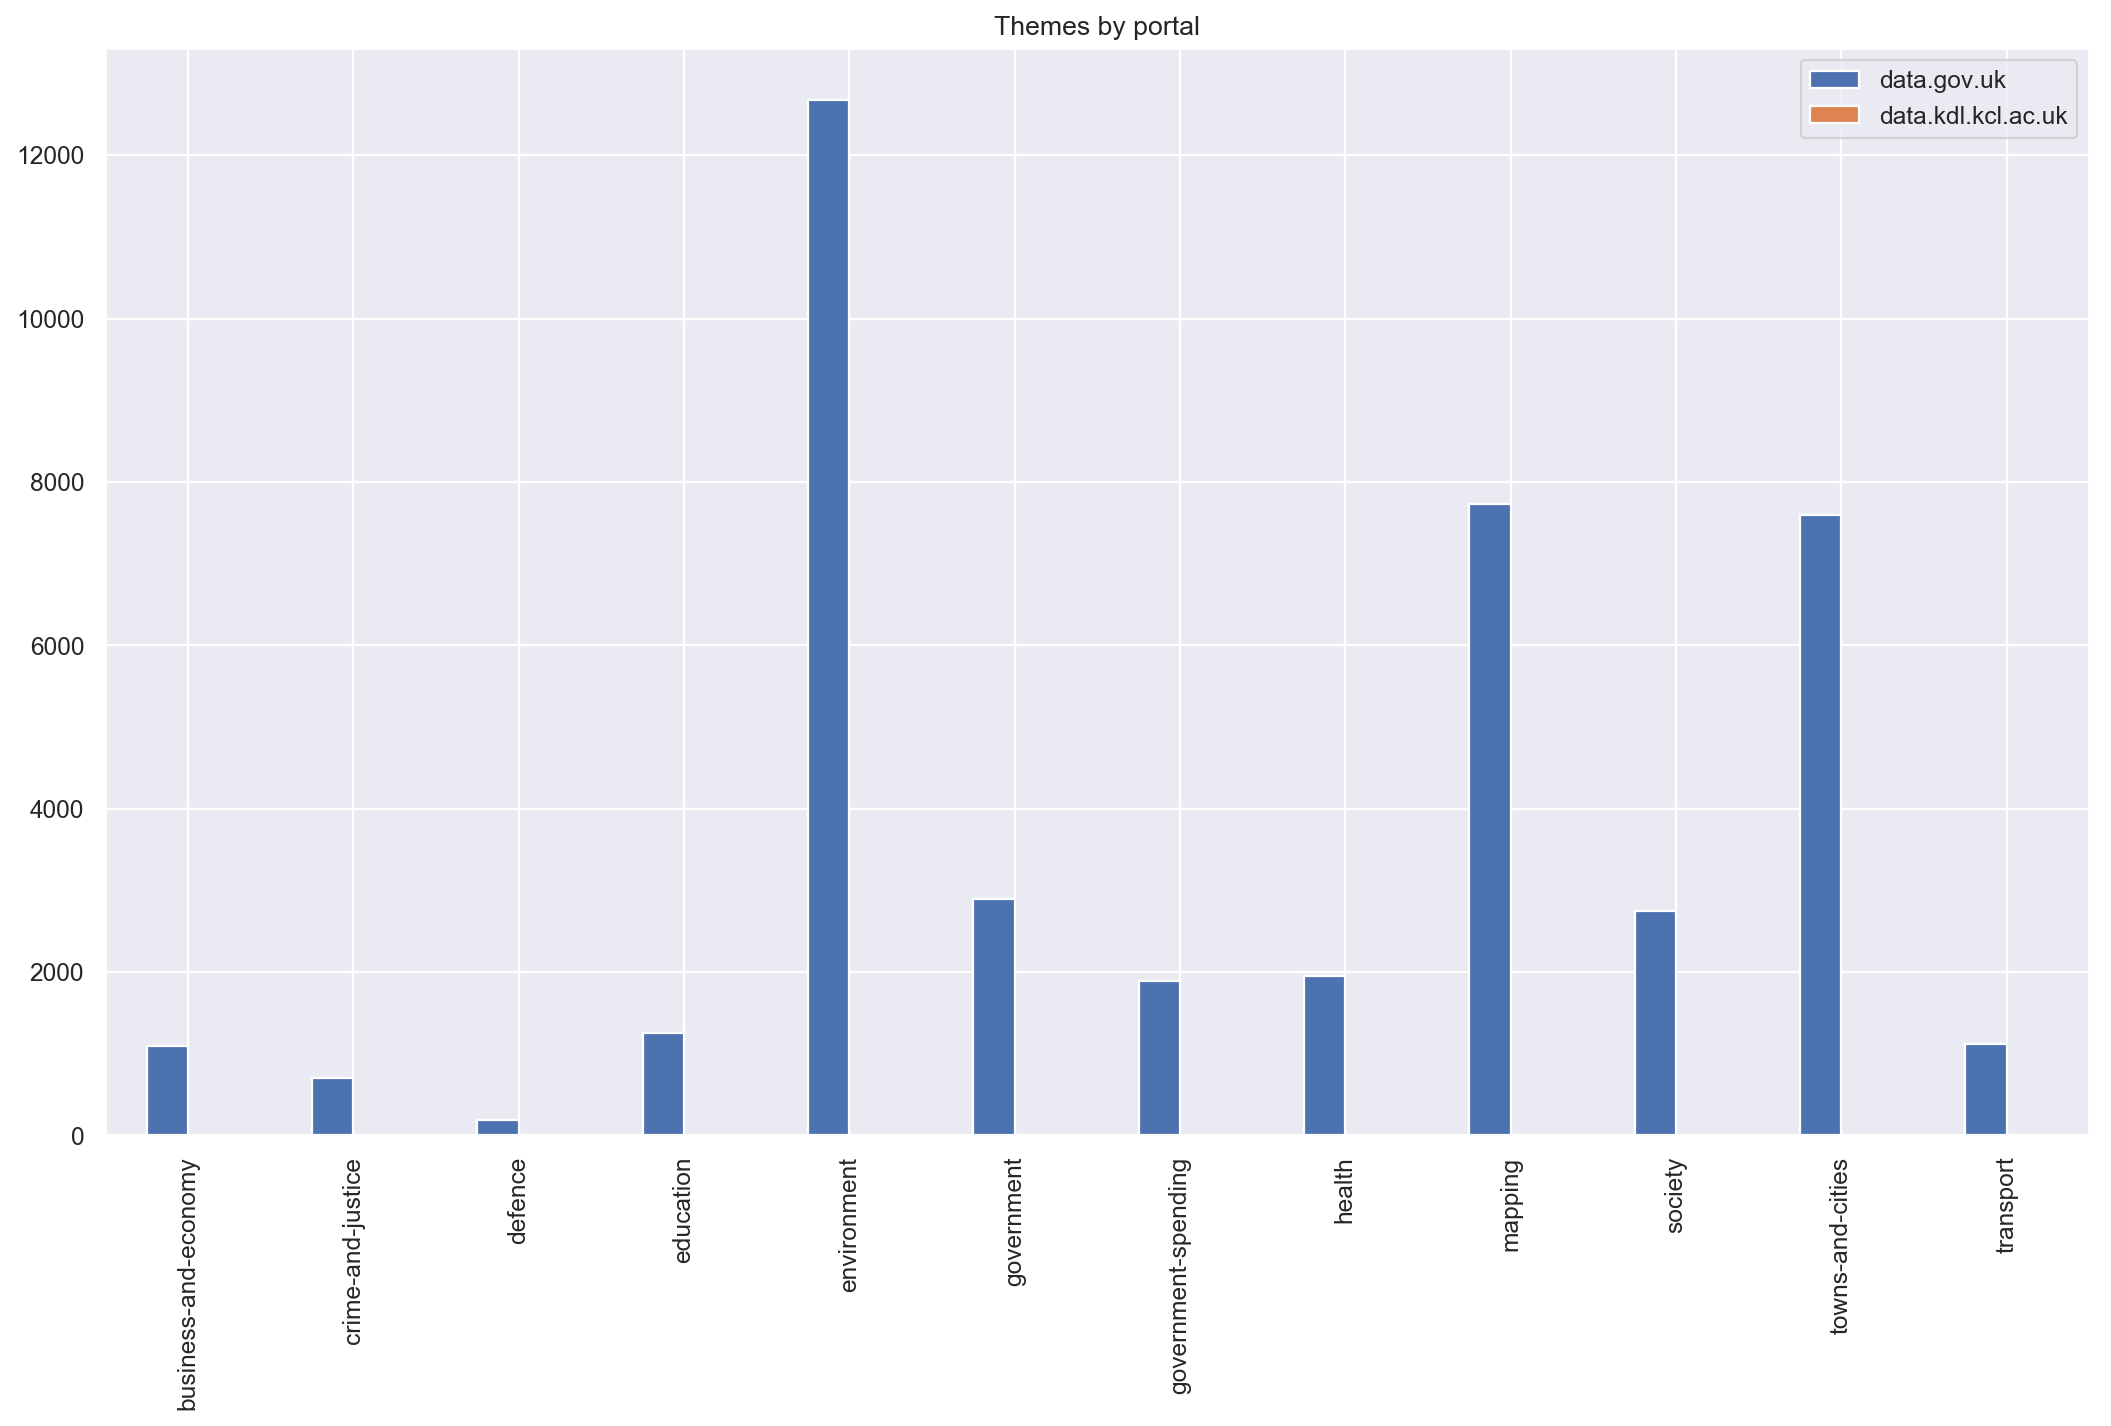

In [295]:
themes_df.plot.bar(title='Themes by portal')

### Packages

In [296]:
packages_df.head()

,__portal__,author,author_email,codelist,contact-email,contact-name,contact-phone,creator_user_id,foi-email,foi-name,...,temporal_granularity,odi-certificate,kdl_project_citation,kdl_project_end_date,kdl_project_funder,kdl_project_pi,kdl_project_start_date,kdl_project_status,kdl_project_team,kdl_project_url
0,data.gov.uk,NaN,NaN,NaN,NaN,NaN,NaN,ee3e01c4-665d-4cc8-9424-0fb055018041,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,data.gov.uk,NaN,NaN,NaN,kuldip.osborne@education.gov.uk,Kuldip Osborne,NaN,fb1da697-ff3d-4e5b-9b06-ebaee8c4eae2,NaN,Ministerial and Public Communications Division,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,data.gov.uk,NaN,NaN,NaN,NaN,NaN,NaN,acd129e9-b544-44f8-b82a-fda3d2c42a06,FOI@Rushmoor.gov.uk,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,data.gov.uk,NaN,NaN,NaN,NaN,NaN,NaN,6dfde375-d752-4a29-a5e1-0acec0864170,ldf@worcester.gov.uk,Worcester City Council,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,data.gov.uk,NaN,NaN,NaN,NaN,NaN,NaN,60e687bf-a6d8-43e2-a50e-efab84b27952,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [297]:
pprint(packages_df.columns)

Index(['__portal__', 'author', 'author_email', 'codelist', 'contact-email',
       'contact-name', 'contact-phone', 'creator_user_id', 'foi-email',
       'foi-name', 'foi-phone', 'foi-web', 'groups', 'id', 'isopen',
       'licence-custom', 'license_id', 'license_title', 'license_url',
       'maintainer', 'maintainer_email', 'metadata_created',
       'metadata_modified', 'name', 'notes', 'num_resources', 'num_tags',
       'organization:approval_status', 'organization:created',
       'organization:description', 'organization:id', 'organization:image_url',
       'organization:is_organization', 'organization:name',
       'organization:revision_id', 'organization:state', 'organization:title',
       'organization:type', 'owner_org', 'private', 'relationships_as_object',
       'relationships_as_subject', 'revision_id', 'schema-vocabulary', 'state',
       'tags', 'theme-primary', 'title', 'type', 'url', 'version', 'extras',
       'theme-secondary', 'temporal_coverage-from', 'tempor

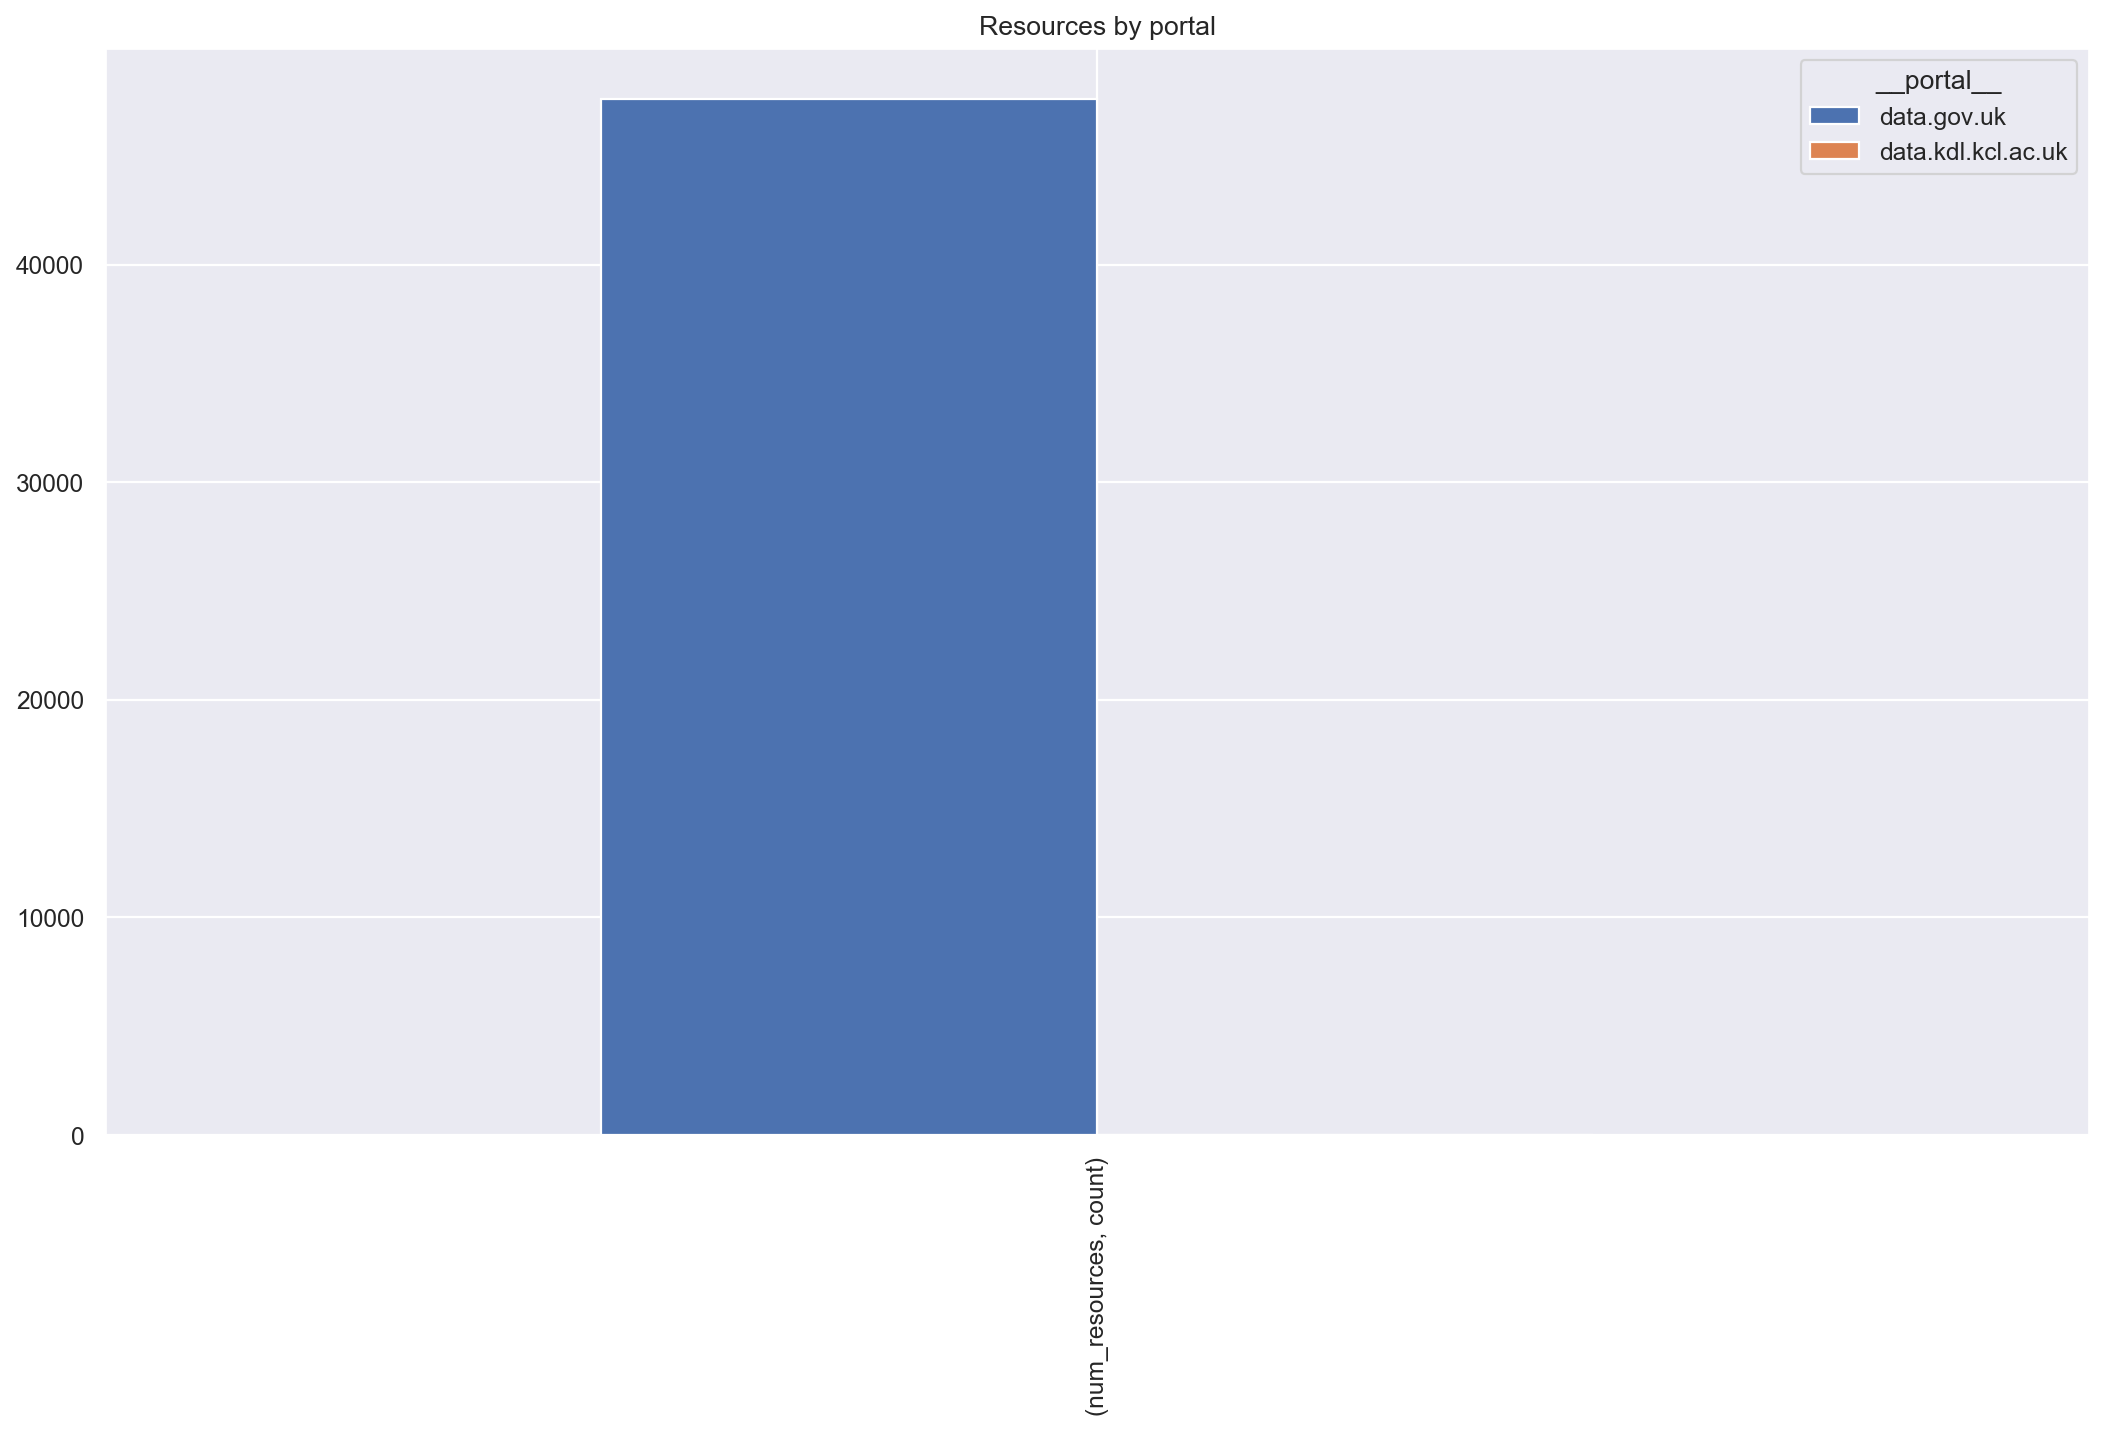

In [314]:
packages_df.groupby(by='__portal__').describe().transpose()[:1].plot.bar(title='Resources by portal')